# Zillow

## Exploratory Analysis of Zillow Data

In [1]:
import numpy as np
import pandas as pd

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# default pandas decimal number display format
pd.options.display.float_format = '{:.2f}'.format

# Split 
from sklearn.model_selection import train_test_split

# Scale
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import sklearn.preprocessing

# Stats
import scipy.stats as stats

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

#My Files
import env
from wrangle_zillow import *

# Clustering
from sklearn.cluster import KMeans

Can leave unscaled for exploration, but scale before modeling!!


In [2]:
# aquire zillow data using function from wrangle_zillow
df = wrangle_zillow()
df.head()

,bathrooms,bedrooms,area,counties,latitude,longitude,lot_area,regionidcity,regionidcounty,regionidzip,...,landtaxvalue,taxamount,logerror,transactiondate,los_angeles,orange,ventura,age,age_bin,bath_bed_ratio
0,3.50,4,3100,orange,33634931,-117869207,4506,53571.00,1286,96978,...,537569,11013,0.03,2017-01-01,0,1,0,19,"(10, 20]",0.88
1,1.00,2,1465,ventura,34449266,-119281531,12647,13091.00,2061,97099,...,376000,5672,0.06,2017-01-01,0,0,1,50,"(40, 50]",0.50
2,2.00,3,1243,orange,33886168,-117823170,8432,21412.00,1286,97078,...,479489,6488,0.01,2017-01-01,0,1,0,55,"(50, 60]",0.67
3,3.00,4,2376,los_angeles,34245180,-118240722,13038,396551.00,3101,96330,...,36225,1777,-0.10,2017-01-01,1,0,0,47,"(40, 50]",0.75
6,3.00,4,2962,los_angeles,34145202,-118179824,63000,47019.00,3101,96293,...,496619,9516,-0.00,2017-01-01,1,0,0,67,"(60, 70]",0.75


In [3]:
df.shape


(50782, 25)

In [4]:
# split data using function from
train, validate, test = split_data(df)

In [5]:
# scaler, train_scaled, validate_scaled, test_scaled = min_max_scaler(train, validate, test)

In [6]:
# train_scaled.head()

1. Ask at least 5 questions about the data, keeping in mind that your target variable is logerror. e.g. Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?

#### Notes: 

target = logerror

log_error = difference of log(Zestimate) and log(SalePrice)

Q: Why did Zillow pick the log error instead of an absolute error metric such as RMSE?

Home sale prices have a right skewed distribution and are also strongly heteroscedastic, so we need to use a relative error metric instead of an absolute metric to ensure valuation models are not biased towards expensive homes. A relative error metric like the percentage error or log ratio error avoids these problems. While we report Zestimate errors in terms of percentages on Zillow.com because we believe that to be a more intuitive metric for consumers, we do not advocate using percentage error to evaluate models in Zillow Prize, as it may lead to biased models The log error is free of this bias problem and when using the natural logarithm, errors close to 1 approximate percentage errors quite closely. See this paper for more on relative errors and why log error should be used instead of percentage error.

https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2635088

#### Questions: 

1. Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?
2. Is there a relationship between logerror and transactiondate?
3. Is there a relationship between logerror and age? 
4. Is there a relationship between logerror and area? 
5. Is there a relationship between logerror and longitude and lattitude? 

2. Answer those questions through a mix of statistical tests and visualizations.

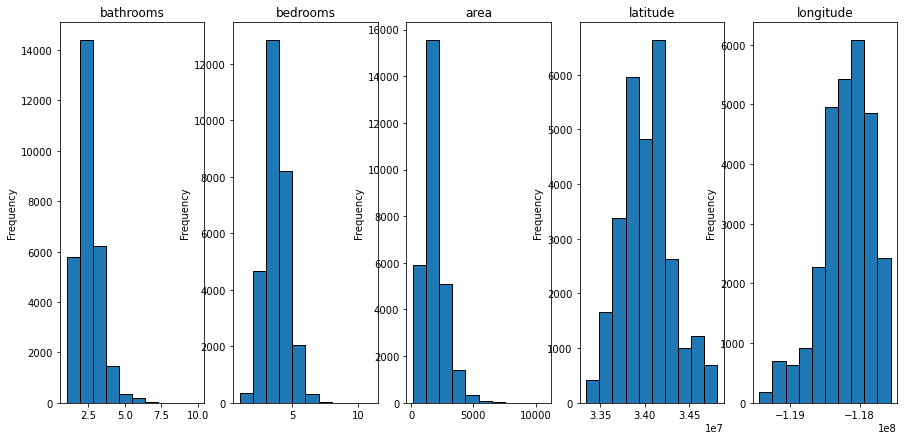

In [7]:
fig, axs = plt.subplots(1, 5, figsize=(15, 7))

for ax, col in zip(axs, train.select_dtypes('number')):
    train[col].plot.hist(ax=ax, title=col, ec='black')

Question 1: 

Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?

Orange county has a greater log error than L.A. and Ventura counties; Ventura having the lowest log error. The mean log error is 0.02. L.A. and Ventura are below the average and Orange County is above the average log error. Using an Kruskal test, it can be concluded from the low P score that the average logerrors are significanly different across all couties.

Visual: 

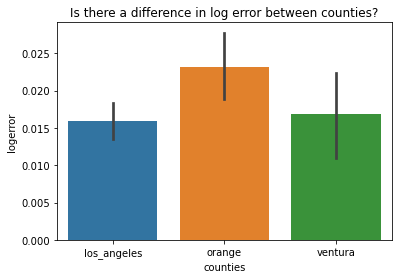

In [8]:
sns.barplot(data=train, y='logerror', x='counties')
plt.title("Is there a difference in log error between counties?")
plt.show()


Stats Testing: 

Levene's Test: tests whether the three means that have been taken from sample populations that have equal variance

Null Hypothesis: There is no difference in log errors variance between the three samples

Alternaive Hypothesis: There is a difference in log errors variance between the three samples

In [9]:
stats.levene(
    df[df.counties == 'los_angeles'].logerror,
    df[df.counties == 'orange'].logerror,
    df[df.counties == 'ventura'].logerror,
)

LeveneResult(statistic=31.475485549598137, pvalue=2.1819081636076963e-14)

A low P value, means we can reject the null hypothesis, that there is no difference in log errors variance between the three samples.

Because Variances were not equal, I used a Kruskal test to calculate the P. 


In [10]:
null_hypothesis = "Average logerrors are the same across all counties"
alternative_hypothesis = "Average logerrors are different across all counties"
alpha = 0.05 # I will be 95% certain the results I see aren't due to chance/randomness


In [11]:
stats.kruskal(
    train[train.counties == 'los_angeles'].logerror,
    train[train.counties == 'orange'].logerror,
    train[train.counties == 'ventura'].logerror,
)

KruskalResult(statistic=24.886270498538202, pvalue=3.9447094787954245e-06)

In [12]:
p = 0.0000039447094787954245
if p < alpha:
    print("We reject the null hypothesis that", null_hypothesis)
    print("We move forward with the alternative hypothesis that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("Evidence does not support the claim that average logerrors are different across all counties.")

We reject the null hypothesis that Average logerrors are the same across all counties
We move forward with the alternative hypothesis that Average logerrors are different across all counties


A low P value means that we can reasonably reject the null hypothesis and move foraward with the idea that Average logerrors are different across all couties.

Question 2: 

Is there a relationship between logerror and bath_bed_ratio?

Question 4:

Is there a relationship between logerror and latitude?

In [13]:
null_hypothesis = "There is no correlation between latitude and log error ."
alternative_hypothesis = "There is a correlation between latitude and log error ."
alpha = 0.05 # I will be 99% certain the results I see aren't due to chance/randomness

In [14]:
x = train.latitude
y = train.logerror

In [15]:
corr, p = stats.pearsonr(x, y)
corr, p

(-0.011689411865214936, 0.04870120892543511)

In [16]:
p = 0.04870120892543511
if p < alpha:
    print("We reject the null hypothesis that", null_hypothesis)
    print("We move forward with the alternative hypothesis that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("Evidence does not support the claim that there is a correlation between latitude and log error.")

We reject the null hypothesis that There is no correlation between latitude and log error .
We move forward with the alternative hypothesis that There is a correlation between latitude and log error .


Question 5: 

Is there a relationship between logerror and longitude?

In [17]:
null_hypothesis = "There is no correlation between longitude and log error ."
alternative_hypothesis = "There is a correlation between longitude and log error ."
alpha = 0.01 # I will be 99% certain the results I see aren't due to chance/randomness

In [18]:
x = train.longitude
y = train.logerror

In [19]:
corr, p = stats.pearsonr(x, y)
corr, p

(0.016816279195372853, 0.00457037578238294)

In [20]:
p = 0.04870120892543511
if p < alpha:
    print("We reject the null hypothesis that", null_hypothesis)
    print("We move forward with the alternative hypothesis that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("Evidence does not support the claim that there is a correlation between longitude and log error.")

We fail to reject the null hypothesis
Evidence does not support the claim that there is a correlation between longitude and log error.


#### Question 1 Scratchpad Section: 

In [21]:
train.describe()

,bathrooms,bedrooms,area,latitude,longitude,lot_area,regionidcity,roomcnt,yearbuilt,structuretaxvalue,taxvalue,landtaxvalue,taxamount,logerror,los_angeles,orange,ventura,age,bath_bed_ratio
count,28437.00,28437.00,28437.00,28437.00,28437.00,28437.00,28437.00,28437.00,28437.00,28437.00,28437.00,28437.00,28437.00,28437.00,28437.00,28437.00,28437.00,28437.00,28437.00
mean,2.25,3.28,1857.23,34024832.17,-118191297.62,11417.18,33382.90,1.92,1963.24,171990.86,447824.22,275833.35,5508.97,0.02,0.64,0.27,0.09,53.76,0.69
std,0.93,0.92,852.84,275212.67,357901.21,105468.85,49436.24,3.14,22.91,149790.60,357499.55,257906.64,4168.01,0.18,0.48,0.44,0.28,22.91,0.23
min,1.00,1.00,152.00,33340620.00,-119447944.00,480.00,3491.00,0.00,1878.00,148.00,3254.00,161.00,49.00,-4.66,0.00,0.00,0.00,2.00,0.20
25%,2.00,3.00,1260.00,33826576.00,-118394397.00,5558.00,12447.00,0.00,1950.00,75771.00,190362.00,73622.00,2618.00,-0.02,0.00,0.00,0.00,38.00,0.50
50%,2.00,3.00,1639.00,34021597.00,-118147156.00,6763.00,24812.00,0.00,1961.00,128632.00,364470.00,211882.00,4542.00,0.01,1.00,0.00,0.00,56.00,0.67
75%,3.00,4.00,2243.00,34191116.00,-117928314.00,8568.00,40227.00,5.00,1979.00,214968.00,593747.00,391614.00,7091.00,0.04,1.00,1.00,0.00,67.00,0.80
max,10.00,11.00,10686.00,34818767.00,-117554636.00,6971010.00,396556.00,14.00,2015.00,1646927.00,1996200.00,1850947.00,58634.00,3.39,1.00,1.00,1.00,139.00,7.50


In [22]:
train.counties


12794    los_angeles
76021    los_angeles
16536    los_angeles
114           orange
48044    los_angeles
            ...     
15656    los_angeles
24580    los_angeles
51314        ventura
2812          orange
43905         orange
Name: counties, Length: 28437, dtype: object

In [23]:
train.shape


(28437, 25)

In [24]:
train.logerror.describe()

count   28437.00
mean        0.02
std         0.18
min        -4.66
25%        -0.02
50%         0.01
75%         0.04
max         3.39
Name: logerror, dtype: float64

In [25]:
train.bathrooms.describe()

count   28437.00
mean        2.25
std         0.93
min         1.00
25%         2.00
50%         2.00
75%         3.00
max        10.00
Name: bathrooms, dtype: float64

In [26]:
train.bedrooms.describe()

count   28437.00
mean        3.28
std         0.92
min         1.00
25%         3.00
50%         3.00
75%         4.00
max        11.00
Name: bedrooms, dtype: float64

In [27]:
train.area.describe()

count   28437.00
mean     1857.23
std       852.84
min       152.00
25%      1260.00
50%      1639.00
75%      2243.00
max     10686.00
Name: area, dtype: float64

In [28]:
train.taxvalue.describe()

count     28437.00
mean     447824.22
std      357499.55
min        3254.00
25%      190362.00
50%      364470.00
75%      593747.00
max     1996200.00
Name: taxvalue, dtype: float64

In [29]:
train.columns

Index(['bathrooms', 'bedrooms', 'area', 'counties', 'latitude', 'longitude',
       'lot_area', 'regionidcity', 'regionidcounty', 'regionidzip', 'roomcnt',
       'yearbuilt', 'structuretaxvalue', 'taxvalue', 'assessmentyear',
       'landtaxvalue', 'taxamount', 'logerror', 'transactiondate',
       'los_angeles', 'orange', 'ventura', 'age', 'age_bin', 'bath_bed_ratio'],
      dtype='object')

In [30]:
train.counties.head()

12794    los_angeles
76021    los_angeles
16536    los_angeles
114           orange
48044    los_angeles
Name: counties, dtype: object

In [31]:
train.logerror.head()

12794    0.03
76021    0.15
16536   -0.03
114      0.02
48044    0.02
Name: logerror, dtype: float64

<AxesSubplot:ylabel='Frequency'>

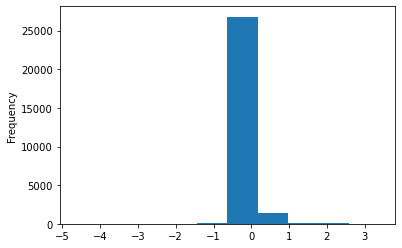

In [32]:
train.logerror.plot.hist()

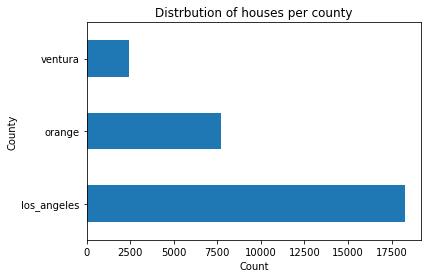

In [33]:
train.counties.value_counts().plot.barh()
plt.title('Distrbution of houses per county')
plt.ylabel('County')
plt.xlabel('Count')
plt.show()

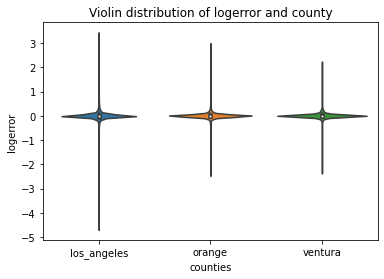

In [34]:
sns.violinplot(data=train, y='logerror', x='counties')
plt.title('Violin distribution of logerror and county')
plt.show()

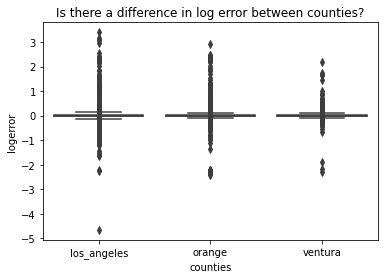

In [35]:
sns.boxplot(data=train, y='logerror', x='counties')
plt.title("Is there a difference in log error between counties?")
plt.show()

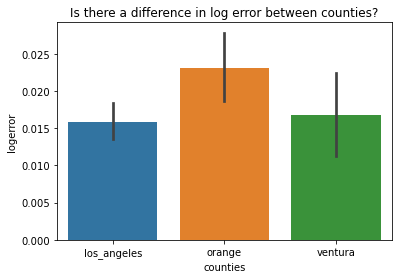

In [36]:
sns.barplot(data=train, y='logerror', x='counties')
plt.title("Is there a difference in log error between counties?")
plt.show()


In [37]:
train.columns


Index(['bathrooms', 'bedrooms', 'area', 'counties', 'latitude', 'longitude',
       'lot_area', 'regionidcity', 'regionidcounty', 'regionidzip', 'roomcnt',
       'yearbuilt', 'structuretaxvalue', 'taxvalue', 'assessmentyear',
       'landtaxvalue', 'taxamount', 'logerror', 'transactiondate',
       'los_angeles', 'orange', 'ventura', 'age', 'age_bin', 'bath_bed_ratio'],
      dtype='object')

Levene's Test: tests whether the three means that have been taken from sample populations that have equal variance

Null Hypothesis: There is no difference in log errors variance between the three samples
Alternaive Hypothesis: There is a difference in log errors variance between the three samples

In [38]:
train[train.counties == 'los_angeles'].logerror

12794    0.03
76021    0.15
16536   -0.03
48044    0.02
76163    0.02
         ... 
40224   -0.08
39535   -0.04
12970   -0.02
15656    0.00
24580   -0.00
Name: logerror, Length: 18299, dtype: float64

In [39]:
stats.levene(
    train[train.counties == 'los_angeles'].logerror,
    train[train.counties == 'orange'].logerror,
    train[train.counties == 'ventura'].logerror,
)

LeveneResult(statistic=18.881553105614774, pvalue=6.386841809908756e-09)

A low P value means we can reasonably reject the null hypothesis that there is no difference in log errors variance between the three samples Alternaive.

In [40]:
print(train.los_angeles.var())

0.2294179319069693


In [41]:
print(train.orange.var())

0.19757517602525537


In [42]:
print(train.ventura.var())

0.07818190232815832


Shouldn't really be using ANOVA test because the variances are not equal. 

In [43]:
# f_oneway is our ANOVA test
# See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html for more info
from scipy.stats import f_oneway

alpha = 0.05

f, p = f_oneway(
    train[train.counties == 'los_angeles'].logerror,
    train[train.counties == 'orange'].logerror,
    train[train.counties == 'ventura'].logerror,
)
p

0.01017851810330212

Because Variances were not equal, I used a Kruskal test to calculate the P. 

In [44]:
stats.kruskal(
    train[train.counties == 'los_angeles'].logerror,
    train[train.counties == 'orange'].logerror,
    train[train.counties == 'ventura'].logerror,
)



KruskalResult(statistic=24.886270498538202, pvalue=3.9447094787954245e-06)

A low P value means that we can reasonably reject the null hypothesis that there is no difference in log errors variance between the three samples

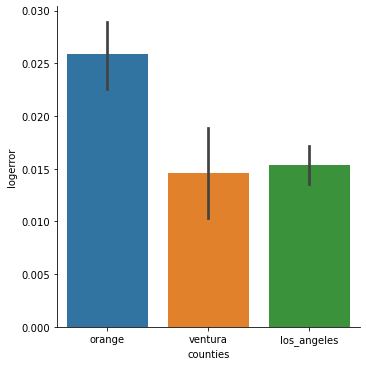

In [45]:
sns.catplot(y='logerror', x='counties', kind="bar", data=df)

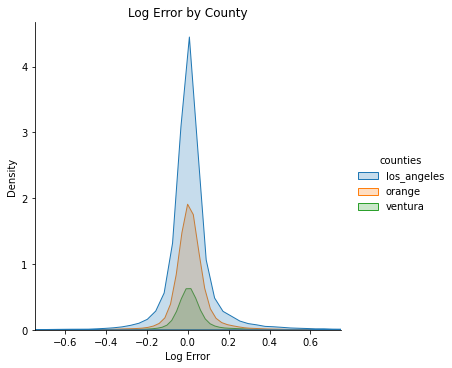

In [46]:
#Plotting distribution of log error by county

sns.displot(train, x='logerror', hue='counties', kind='kde', fill=True)
plt.title('Log Error by County')
plt.xlabel('Log Error')
plt.xlim(-0.75, 0.75)
plt.show()

#### Question 2 Scratchpad Section: 

Is there a relationship between logerror and bath_bed_ratio?

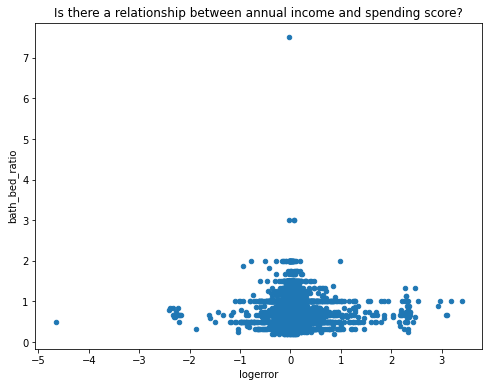

In [47]:
train.plot.scatter(
    x='logerror',
    y='bath_bed_ratio',
    title='Is there a relationship between annual income and spending score?',
    figsize=(8, 6),
)
plt.show()


In [48]:
train.isna().sum()

bathrooms            0
bedrooms             0
area                 0
counties             0
latitude             0
longitude            0
lot_area             0
regionidcity         0
regionidcounty       0
regionidzip          0
roomcnt              0
yearbuilt            0
structuretaxvalue    0
taxvalue             0
assessmentyear       0
landtaxvalue         0
taxamount            0
logerror             0
transactiondate      0
los_angeles          0
orange               0
ventura              0
age                  0
age_bin              0
bath_bed_ratio       0
dtype: int64

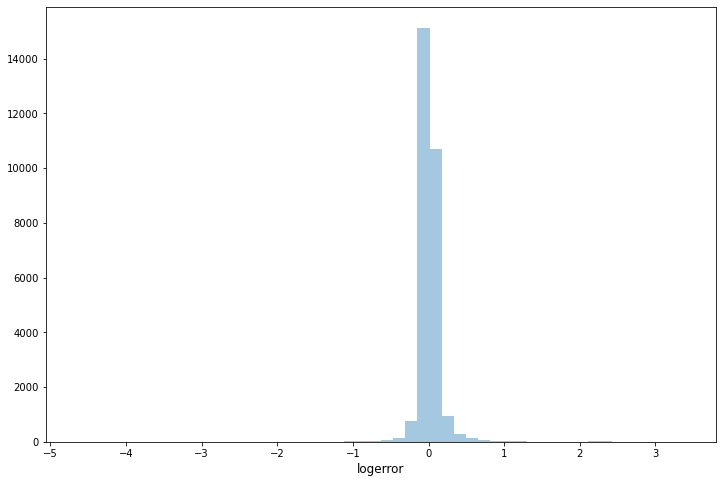

In [49]:
plt.figure(figsize=(12,8))
sns.distplot(train.logerror.values, bins=50, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()



In [50]:
train.transactiondate.head()

12794    2017-02-27
76021    2017-09-13
16536    2017-03-13
114      2017-01-03
48044    2017-06-20
Name: transactiondate, dtype: object

In [51]:
train.columns

Index(['bathrooms', 'bedrooms', 'area', 'counties', 'latitude', 'longitude',
       'lot_area', 'regionidcity', 'regionidcounty', 'regionidzip', 'roomcnt',
       'yearbuilt', 'structuretaxvalue', 'taxvalue', 'assessmentyear',
       'landtaxvalue', 'taxamount', 'logerror', 'transactiondate',
       'los_angeles', 'orange', 'ventura', 'age', 'age_bin', 'bath_bed_ratio'],
      dtype='object')

In [52]:
train.age.describe()

count   28437.00
mean       53.76
std        22.91
min         2.00
25%        38.00
50%        56.00
75%        67.00
max       139.00
Name: age, dtype: float64

In [53]:
train.age_bin.describe()


count        28437
unique          13
top       (60, 70]
freq          7221
Name: age_bin, dtype: object

In [54]:
df.age_bin.value_counts()


(60, 70]      12957
(50, 60]       9263
(40, 50]       5565
(30, 40]       4637
(20, 30]       4336
(10, 20]       4062
(70, 80]       3383
(90, 100]      2753
(80, 90]       1696
(0, 10]        1099
(100, 120]      987
(120, 130]       36
(130, 140]        8
Name: age_bin, dtype: int64

<AxesSubplot:title={'center':'Distribution of age_bin'}>

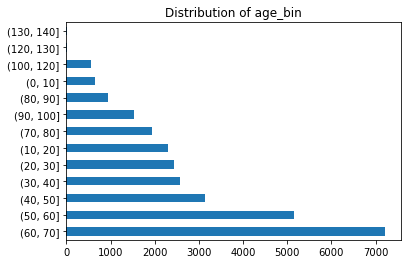

In [55]:
train.age_bin.value_counts().plot.barh(title='Distribution of age_bin')

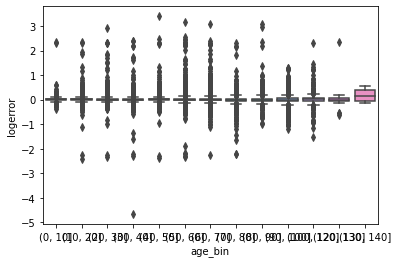

In [56]:
sns.boxplot(data=train, y='logerror', x='age_bin')
plt.show()

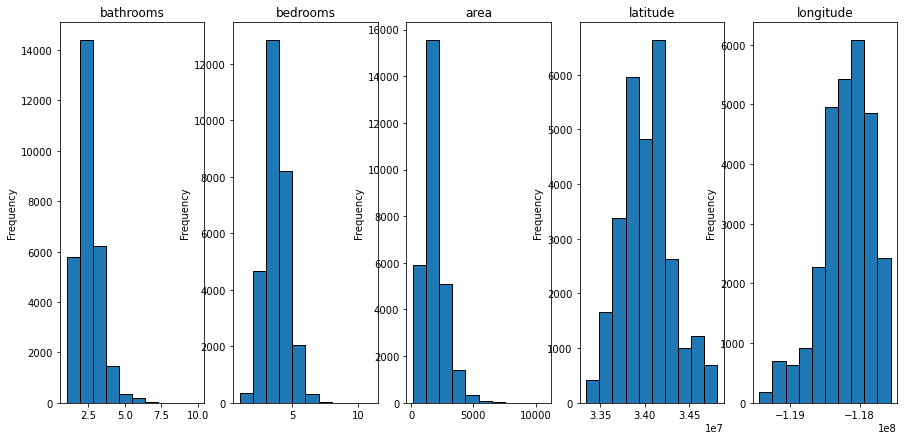

In [57]:
fig, axs = plt.subplots(1, 5, figsize=(15, 7))

for ax, col in zip(axs, train.select_dtypes('number')):
    train[col].plot.hist(ax=ax, title=col, ec='black')

## Prep for Clustering 

Prep and scale before clustering. 

In [58]:
# aquire zillow data using function from wrangle_zillow
df = wrangle_zillow()
df.head()

,bathrooms,bedrooms,area,counties,latitude,longitude,lot_area,regionidcity,regionidcounty,regionidzip,...,landtaxvalue,taxamount,logerror,transactiondate,los_angeles,orange,ventura,age,age_bin,bath_bed_ratio
0,3.50,4,3100,orange,33634931,-117869207,4506,53571.00,1286,96978,...,537569,11013,0.03,2017-01-01,0,1,0,19,"(10, 20]",0.88
1,1.00,2,1465,ventura,34449266,-119281531,12647,13091.00,2061,97099,...,376000,5672,0.06,2017-01-01,0,0,1,50,"(40, 50]",0.50
2,2.00,3,1243,orange,33886168,-117823170,8432,21412.00,1286,97078,...,479489,6488,0.01,2017-01-01,0,1,0,55,"(50, 60]",0.67
3,3.00,4,2376,los_angeles,34245180,-118240722,13038,396551.00,3101,96330,...,36225,1777,-0.10,2017-01-01,1,0,0,47,"(40, 50]",0.75
6,3.00,4,2962,los_angeles,34145202,-118179824,63000,47019.00,3101,96293,...,496619,9516,-0.00,2017-01-01,1,0,0,67,"(60, 70]",0.75


In [59]:
# split data using function from
train, validate, test = split_data(df)

In [60]:
train.head()

,bathrooms,bedrooms,area,counties,latitude,longitude,lot_area,regionidcity,regionidcounty,regionidzip,...,landtaxvalue,taxamount,logerror,transactiondate,los_angeles,orange,ventura,age,age_bin,bath_bed_ratio
12794,2.00,4,1352,los_angeles,34273883,-118492869,6925,12447.00,3101,96370,...,357000,6228,0.03,2017-02-27,1,0,0,62,"(60, 70]",0.50
76021,3.00,4,1980,los_angeles,34362339,-117653901,8763,21395.00,3101,97324,...,59894,3275,0.15,2017-09-13,1,0,0,36,"(30, 40]",0.75
16536,3.00,3,1484,los_angeles,34288283,-118376120,12470,12447.00,3101,96368,...,133593,3881,-0.03,2017-03-13,1,0,0,27,"(20, 30]",1.00
114,2.00,3,1731,orange,33883151,-117869121,8000,26531.00,1286,97068,...,21263,1353,0.02,2017-01-03,0,1,0,54,"(50, 60]",0.67
48044,1.00,3,1011,los_angeles,33921848,-118247414,5970,118994.00,3101,96040,...,92683,2101,0.02,2017-06-20,1,0,0,71,"(70, 80]",0.33


In [61]:
train.dtypes

bathrooms             float64
bedrooms                int64
area                    int64
counties               object
latitude                int64
longitude               int64
lot_area                int64
regionidcity          float64
regionidcounty         object
regionidzip            object
roomcnt               float64
yearbuilt             float64
structuretaxvalue       int64
taxvalue                int64
assessmentyear         object
landtaxvalue            int64
taxamount               int64
logerror              float64
transactiondate        object
los_angeles             uint8
orange                  uint8
ventura                 uint8
age                     int64
age_bin              category
bath_bed_ratio        float64
dtype: object

In [62]:
# Split into X and y variables

In [63]:
# Run split_tvt_into_variables / the target is tax_value
# train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = split_tvt_into_variables(train, validate, test, target='logerror')

In [64]:
# X_train.shape

In [65]:
# X_train.head()

In [66]:
# Scale the data

In [67]:
# scaler, X_train_scaled, X_validate_scaled, X_test_scaled = Min_Max_Scaler(X_train, X_validate, X_test)

In [68]:
# X_train_scaled.shape

In [69]:
# X_train_scaled.head()

## Clustering

In [70]:
# functions to create clusters and scatter-plot:


def create_cluster(df, X, k):
    
    """ Takes in df, X (dataframe with variables you want to cluster on) and k
    # It scales the X, calcuates the clusters and return train (with clusters), the Scaled dataframe,
    #the scaler and kmeans object and unscaled centroids as a dataframe"""
    
    scaler = StandardScaler(copy=True).fit(X)
    X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns.values).set_index([X.index.values])
    kmeans = KMeans(n_clusters = k, random_state = 42)
    kmeans.fit(X_scaled)
    kmeans.predict(X_scaled)
    df['cluster'] = kmeans.predict(X_scaled)
    df['cluster'] = 'cluster_' + df.cluster.astype(str)
    centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)
    return df, X_scaled, scaler, kmeans, centroids


def create_scatter_plot(x,y,df,kmeans, X_scaled, scaler):
    
    """ Takes in x and y (variable names as strings, along with returned objects from previous
    function create_cluster and creates a plot"""
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x = x, y = y, data = df, hue = 'cluster')
    centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)
    centroids.plot.scatter(y=y, x= x, ax=plt.gca(), alpha=.30, s=500, c='black')

Clustering on latitude and longitude first. 

In [71]:
# we will create cluster on two features

X = train[['latitude', 'longitude']]

In [72]:
# use the functions I created above

train, X_scaled, scaler, kmeans, centroids = create_cluster(train, X, 3)

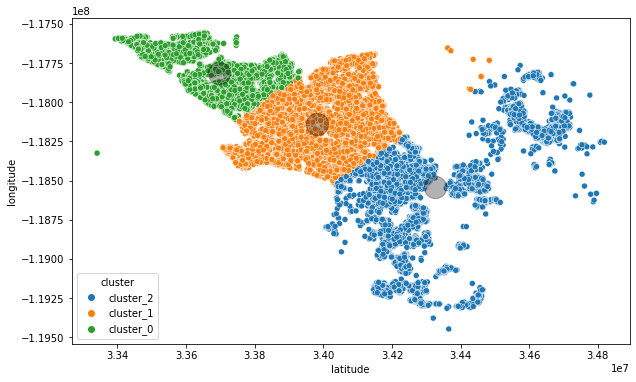

In [73]:
# use the functions I created above to plot the data

create_scatter_plot('latitude', 'longitude', train, kmeans, X_scaled, scaler)


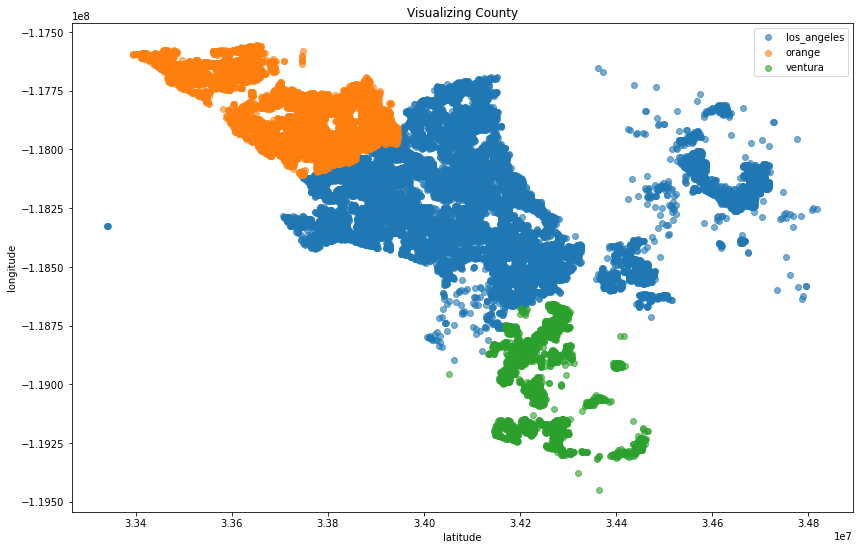

In [74]:
plt.figure(figsize=(14, 9))
for cluster, subset in train.groupby('counties'):
    plt.scatter(subset.latitude, subset.longitude, label=str(cluster), alpha=.6)
# centroids.plot.scatter(y='petal_length', x='sepal_length', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.title('Visualizing County')
plt.show()

In [75]:
train, X_scaled, scaler, kmeans, centroids = create_cluster(train, X, 4)

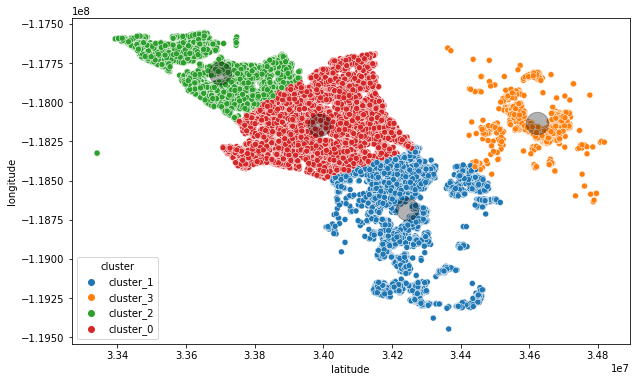

In [76]:
create_scatter_plot('latitude', 'longitude', train, kmeans, X_scaled, scaler)

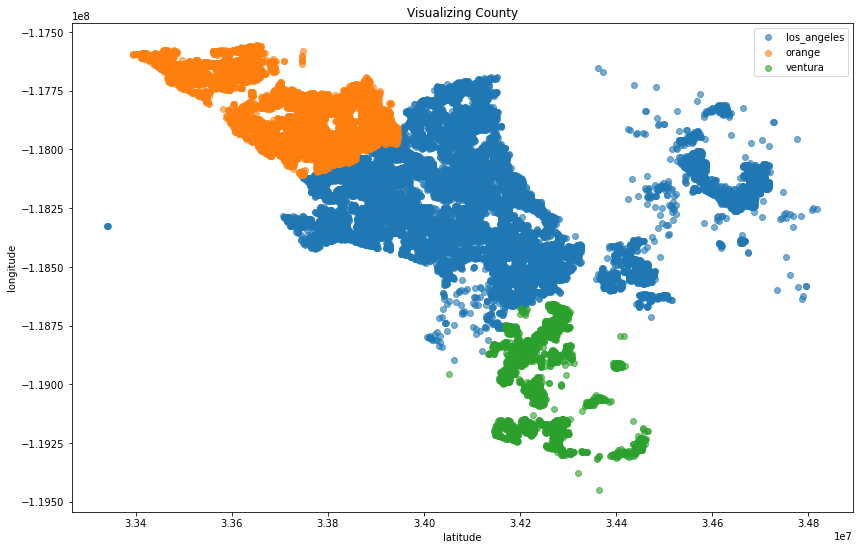

In [77]:
plt.figure(figsize=(14, 9))
for cluster, subset in train.groupby('counties'):
    plt.scatter(subset.latitude, subset.longitude, label=str(cluster), alpha=.6)
# centroids.plot.scatter(y='petal_length', x='sepal_length', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.title('Visualizing County')
plt.show()

Text(0.5, 1.0, 'Looking at log error by location and cluster')

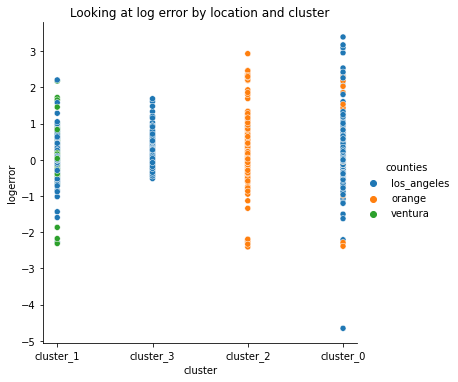

In [78]:
sns.relplot(
    x='cluster',
    y='logerror',
    data=train, hue='counties'
)
plt.title("Looking at log error by location and cluster")

In [108]:
# saving lat/long clustering to use later in stats testing and modeling
train['lat_long_cluster'] = [x.strip()[-1] for x in train['cluster']]
train['lat_long_cluster'] = pd.to_numeric(train['lat_long_cluster'],errors='coerce')

train.head()

,bathrooms,bedrooms,area,counties,latitude,longitude,lot_area,regionidcity,regionidcounty,regionidzip,...,logerror,transactiondate,los_angeles,orange,ventura,age,age_bin,bath_bed_ratio,cluster,lat_long_cluster
12794,2.00,4,1352,los_angeles,34273883,-118492869,6925,12447.00,3101,96370,...,0.03,2017-02-27,1,0,0,62,"(60, 70]",0.50,cluster_0,0
76021,3.00,4,1980,los_angeles,34362339,-117653901,8763,21395.00,3101,97324,...,0.15,2017-09-13,1,0,0,36,"(30, 40]",0.75,cluster_2,2
16536,3.00,3,1484,los_angeles,34288283,-118376120,12470,12447.00,3101,96368,...,-0.03,2017-03-13,1,0,0,27,"(20, 30]",1.00,cluster_0,0
114,2.00,3,1731,orange,33883151,-117869121,8000,26531.00,1286,97068,...,0.02,2017-01-03,0,1,0,54,"(50, 60]",0.67,cluster_4,4
48044,1.00,3,1011,los_angeles,33921848,-118247414,5970,118994.00,3101,96040,...,0.02,2017-06-20,1,0,0,71,"(70, 80]",0.33,cluster_4,4


In [110]:
train.dtypes

bathrooms             float64
bedrooms                int64
area                    int64
counties               object
latitude                int64
longitude               int64
lot_area                int64
regionidcity          float64
regionidcounty         object
regionidzip            object
roomcnt               float64
yearbuilt             float64
structuretaxvalue       int64
taxvalue                int64
assessmentyear         object
landtaxvalue            int64
taxamount               int64
logerror              float64
transactiondate        object
los_angeles             uint8
orange                  uint8
ventura                 uint8
age                     int64
age_bin              category
bath_bed_ratio        float64
cluster                object
lat_long_cluster        int64
dtype: object

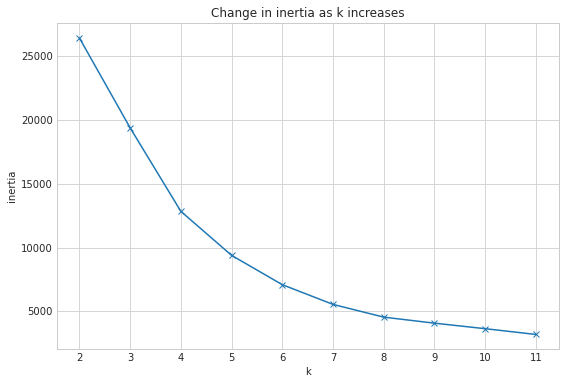

In [111]:
# lets plot inertia vs k

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')


In [112]:
train, X_scaled, scaler, kmeans, centroids = create_cluster(train, X, 5)

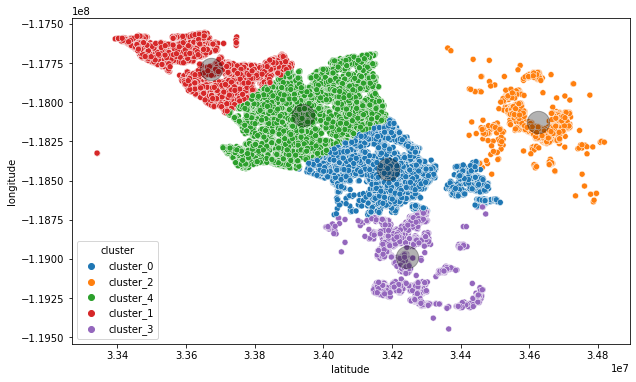

In [113]:
create_scatter_plot('latitude', 'longitude', train, kmeans, X_scaled, scaler)

Results of clustering on longitude and latitude: 
Three clusters is pretty close to how the three counties are already represented, however four clusters might be better because los angles is so large and is better represented by two clusters. 

In [121]:
stats.levene(
    train[train.lat_long_cluster == 0 ].logerror,
    train[train.lat_long_cluster == 1 ].logerror,
    train[train.lat_long_cluster == 2 ].logerror,
    train[train.lat_long_cluster == 3 ].logerror,
    train[train.lat_long_cluster == 4 ].logerror,
)

LeveneResult(statistic=8.04034140923779, pvalue=1.787467336561188e-06)

A low P value, means we can reject the null hypothesis, that there is no difference in log errors variance between the five samples.

Because Variances were not equal, I used a Kruskal test to calculate the P. 

In [123]:
null_hypothesis = "Average logerrors are the same across all lat/long clusters"
alternative_hypothesis = "Average logerrors are different across all lat/long clusters"
alpha = 0.05 # I will be 95% certain the results I see aren't due to chance/randomness


In [120]:
stats.kruskal(
    train[train.lat_long_cluster == 0 ].logerror,
    train[train.lat_long_cluster == 1 ].logerror,
    train[train.lat_long_cluster == 2 ].logerror,
    train[train.lat_long_cluster == 3 ].logerror,
    train[train.lat_long_cluster == 4 ].logerror,
)

KruskalResult(statistic=37.93850121364737, pvalue=1.1537744113879483e-07)

In [125]:
p = 0.00000011537744113879483
if p < alpha:
    print("We reject the null hypothesis that", null_hypothesis)
    print("We move forward with the alternative hypothesis that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("Evidence does not support the claim that average logerrors are different across all counties.")

We reject the null hypothesis that Average logerrors are the same across all lat/long clusters
We move forward with the alternative hypothesis that Average logerrors are different across all lat/long clusters
